# Notebook 02: Data Preprocessing


## 1. Data Loading and Initial Processing

### 1.1 Dataset Import



In [317]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

print("Dataset Import Validation:")
print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")

# Create combined dataset for consistent feature processing
df_combined = pd.concat([
    df_train.drop('SalePrice', axis=1),
    df_test
], ignore_index=True)
df_combined['dataset_source'] = ['train']*len(df_train) + ['test']*len(df_test)

print(f"Combined dataset: {df_combined.shape}")


Dataset Import Validation:
Training data: (1460, 81)
Test data: (1459, 80)
Combined dataset: (2919, 81)


### 1.2 Parser Integration Setup

In [318]:
# Setup data description parser for domain knowledge
from data_description_parser import (
    load_feature_descriptions,
    quick_feature_lookup,
    display_summary_table,
    get_categorical_features,
    get_numerical_features,
    search_feature
)

# Load official documentation
feature_descriptions = load_feature_descriptions()
print("Parser Integration Setup:")

# Get feature classifications for preprocessing
categorical_features = get_categorical_features(feature_descriptions)
numerical_features = get_numerical_features(feature_descriptions)

print(f"Categorical features identified: {len(categorical_features)}")
print(f"Numerical features identified: {len(numerical_features)}")

Parser Integration Setup:
Categorical features identified: 46
Numerical features identified: 33


Parser confirms 46 categorical and 33 numerical features with 3 critical misclassifications requiring correction.
Official documentation provides guidance for every preprocessing decision.

## 2. Feature Classification Correction

Correct feature type misclassifications before proceeding with missing data treatment or encoding.
Ordinal features require different treatment than continuous numerical variables.

### 2.1 Ordinal Feature Correction

Convert three features (OverallQual, OverallCond, MSSubClass) from integers to proper categorical types.
This correction ensures ordinal relationships are preserved during encoding.

In [319]:
# Correct misclassified ordinal features identified in Notebook 01
ordinal_features = ['OverallQual', 'OverallCond', 'MSSubClass']

print("Ordinal Feature Correction:")

# Show current state before correction
print(f"\nBefore correction:")
for feature in ordinal_features:
    dtype = df_combined[feature].dtype
    unique_vals = sorted(df_combined[feature].unique())
    print(f"  {feature}: {dtype} with {len(unique_vals)} unique values: {unique_vals}")

# Convert to ordered categorical for combined dataset
print(f"\nApplying corrections:")
for feature in ordinal_features:
    if feature == 'MSSubClass':
        # MSSubClass: dwelling type categories
        print(f"  {feature}: Converting to unordered categorical (dwelling types)")
        df_combined[feature] = df_combined[feature].astype('category')
    else:
        # OverallQual and OverallCond: 1-10 quality scales
        print(f"  {feature}: Converting to ordered categorical (quality scale)")
        df_combined[feature] = pd.Categorical(df_combined[feature],
                                            categories=sorted(df_combined[feature].unique()),
                                            ordered=True)

print(f"\nAfter correction:")
for feature in ordinal_features:
    dtype = df_combined[feature].dtype
    is_ordered = hasattr(df_combined[feature], 'cat') and df_combined[feature].cat.ordered
    print(f"  {feature}: {dtype} (ordered: {is_ordered})")
    
    # Show categories for verification
    if hasattr(df_combined[feature], 'cat'):
        categories = list(df_combined[feature].cat.categories)
        print(f"    Categories: {categories}")

Ordinal Feature Correction:

Before correction:
  OverallQual: int64 with 10 unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
  OverallCond: int64 with 9 unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
  MSSubClass: int64 with 16 unique values: [np.int64(20), np.int64(30), np.int64(40), np.int64(45), np.int64(50), np.int64(60), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(120), np.int64(150), np.int64(160), np.int64(180), np.int64(190)]

Applying corrections:
  OverallQual: Converting to ordered categorical (quality scale)
  OverallCond: Converting to ordered categorical (quality scale)
  MSSubClass: Converting to unordered categorical (dwelling types)

After correction:
  OverallQual: category (ordered: True)
    Categories: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  OverallCond: 

Converted 3 misclassified features to proper categorical types. OverallQual and OverallCond now preserve ordinal relationships (1-10 scales), while MSSubClass represents dwelling type categories.

## 3. Outlier Treatment

### 3.1 Outlier Removal



In [321]:

# Remove data quality outliers identified in Notebook 01
outlier_ids = [524, 1299]  # Partial sales of incomplete luxury properties

print(f"Outlier IDs to remove: {outlier_ids}")

# Show outlier characteristics before removal
outlier_analysis = df_train[df_combined['Id'].isin(outlier_ids)]
print(f"\nOutlier characteristics:")
for idx, row in outlier_analysis.iterrows():
    print(f"  ID {row['Id']}: {row['GrLivArea']:.0f} sqft, ${row['SalePrice']:,}, OverallQual={row['OverallQual']}")

# Remove outliers from both datasets
before_train_count = len(df_train)
before_combined_count = len(df_combined)

df_train = df_train[~df_train['Id'].isin(outlier_ids)].reset_index(drop=True)
df_combined = df_combined[~df_combined['Id'].isin(outlier_ids)].reset_index(drop=True)

after_train_count = len(df_train)
after_combined_count = len(df_combined)

print(f"\nOutlier removal impact:")
print(f"  Training data: {before_train_count} → {after_train_count} samples")
print(f"  Combined data: {before_combined_count} → {after_combined_count} samples")
print(f"  Removed: {before_train_count - after_train_count} samples ({((before_train_count - after_train_count) / before_train_count) * 100:.2f}%)")



Outlier IDs to remove: [524, 1299]

Outlier characteristics:

Outlier removal impact:
  Training data: 1458 → 1458 samples
  Combined data: 2917 → 2917 samples
  Removed: 0 samples (0.00%)


Targeted outlier removal eliminates two data quality issues while preserving 99.86% of training data.

### 3.2 Impact Assessment

Assess impact of outlier removal on target variable

In [322]:
# Calculate statistics before outlier removal for comparison
df_train_original = pd.read_csv('../data/raw/train.csv')  # Reload original for comparison
df_train_original['SalePrice_log'] = np.log1p(df_train_original['SalePrice'])

print("Outlier Removal Impact Assessment:")

# Before/after comparison for SalePrice statistics
print(f"SalePrice statistics comparison:")
print(f"  Mean: ${df_train_original['SalePrice'].mean():,.0f} → ${df_train['SalePrice'].mean():,.0f}")
print(f"  Median: ${df_train_original['SalePrice'].median():,.0f} → ${df_train['SalePrice'].median():,.0f}")
print(f"  Std: ${df_train_original['SalePrice'].std():,.0f} → ${df_train['SalePrice'].std():,.0f}")
print(f"  Skewness: {df_train_original['SalePrice'].skew():.4f} → {df_train['SalePrice'].skew():.4f}")


Outlier Removal Impact Assessment:
SalePrice statistics comparison:
  Mean: $180,921 → $180,933
  Median: $163,000 → $163,000
  Std: $79,443 → $79,495
  Skewness: 1.8829 → 1.8813


Outlier removal had minimal impact on price distribution with mean/median stable, std unchanged (~$79k), and skewness slightly improved (1.8829→1.8813)

## 4. Missing Data Treatment

Address 34 features with missing values using a systematic three-tier approach.
Use parser guidance to distinguish between architectural absence and genuine missing data.

### 4.1 Missing Data Analysis

Analyze missing data patterns to organize features for systematic treatment.
This analysis guides our treatment strategy by categorizing different types of missingness.

In [323]:
# Get all features with missing data from combined dataset
missing_data = df_combined.drop('dataset_source', axis=1).isnull().sum()
missing_features = missing_data[missing_data > 0].sort_values(ascending=False)

print("Missing Data Overview:")
print(f"Total features with missing data: {len(missing_features)}")
print(f"Total missing values: {missing_features.sum()}")

print(f"\nAll missing features:")
for feature, count in missing_features.items():
    pct = (count / len(df_combined)) * 100
    print(f"  {feature}: {count} ({pct:.1f}%)")

Missing Data Overview:
Total features with missing data: 34
Total missing values: 15700

All missing features:
  PoolQC: 2908 (99.7%)
  MiscFeature: 2812 (96.4%)
  Alley: 2719 (93.2%)
  Fence: 2346 (80.4%)
  MasVnrType: 1766 (60.5%)
  FireplaceQu: 1420 (48.7%)
  LotFrontage: 486 (16.7%)
  GarageFinish: 159 (5.5%)
  GarageQual: 159 (5.5%)
  GarageCond: 159 (5.5%)
  GarageYrBlt: 159 (5.5%)
  GarageType: 157 (5.4%)
  BsmtExposure: 82 (2.8%)
  BsmtCond: 82 (2.8%)
  BsmtQual: 81 (2.8%)
  BsmtFinType2: 80 (2.7%)
  BsmtFinType1: 79 (2.7%)
  MasVnrArea: 23 (0.8%)
  MSZoning: 4 (0.1%)
  BsmtFullBath: 2 (0.1%)
  BsmtHalfBath: 2 (0.1%)
  Functional: 2 (0.1%)
  Utilities: 2 (0.1%)
  GarageArea: 1 (0.0%)
  GarageCars: 1 (0.0%)
  Electrical: 1 (0.0%)
  KitchenQual: 1 (0.0%)
  TotalBsmtSF: 1 (0.0%)
  BsmtUnfSF: 1 (0.0%)
  BsmtFinSF2: 1 (0.0%)
  BsmtFinSF1: 1 (0.0%)
  Exterior2nd: 1 (0.0%)
  Exterior1st: 1 (0.0%)
  SaleType: 1 (0.0%)


### 4.2 

Gå igennem hver feature og find ud af om den mangler data fordi den ikke eksisterer eller fordi den ikke er målt og bestem så hvordan vi skal håndtere det.

In [324]:
def analyze_feature_missing_data(feature):
    """
    Analyze a single feature's missing data patterns and distribution.
    Automatically uses df_combined for analysis.

    Parameters:
    feature: Feature name to analyze
    """
    missing_count = df_combined[feature].isnull().sum()
    missing_pct = (missing_count / len(df_combined)) * 100

    print(f"\n{feature}")
    print("-" * 50)
    print(f"Missing: {missing_count} values ({missing_pct:.1f}%)")

    # Parser consultation if available
    if 'feature_descriptions' in globals():
        quick_feature_lookup(feature, feature_descriptions)

    # Show feature context and distribution
    if df_combined[feature].dtype == 'object':
        # Categorical feature
        unique_values = df_combined[feature].dropna().unique()
        print(f"Data type: Categorical ({len(unique_values)} unique values)")

        # Value distribution
        value_counts = df_combined[feature].value_counts()
        print(f"Value distribution:")
        for value, count in value_counts.items():
            pct = (count / value_counts.sum()) * 100
            print(f"  {value}: {count} ({pct:.1f}%)")
    else:
        # Numerical feature
        feature_data = df_combined[feature].dropna()
        print(f"Data type: Numerical")
        print(f"Range: {feature_data.min():.1f} - {feature_data.max():.1f}")
        print(f"Stats: Mean={feature_data.mean():.1f}, Median={feature_data.median():.1f}")

        # Check for zero values
        zero_count = (feature_data == 0).sum()
        if zero_count > 0:
            zero_pct = (zero_count / len(feature_data)) * 100
            print(f"Zero values: {zero_count} ({zero_pct:.1f}%)")

#### PoolQC

In [325]:
analyze_feature_missing_data('PoolQC')


PoolQC
--------------------------------------------------
Missing: 2908 values (99.7%)
Feature: PoolQC
Description: Pool quality
Type: Categorical

Categories:
  Ex: Excellent
  Gd: Good
  TA: Average/Typical
  Fa: Fair
  NA: No Pool
------------------------------------------------------------
Data type: Categorical (3 unique values)
Value distribution:
  Ex: 4 (44.4%)
  Gd: 3 (33.3%)
  Fa: 2 (22.2%)


In [326]:
# Filling missing PoolQC with NA
df_combined['PoolQC'].fillna('NA', inplace=True)
print('Missing values in PoolQC after filling with NA:', df_combined['PoolQC'].isnull().sum())

Missing values in PoolQC after filling with NA: 0


#### MiscFeature

In [327]:
analyze_feature_missing_data('MiscFeature')


MiscFeature
--------------------------------------------------
Missing: 2812 values (96.4%)
Feature: MiscFeature
Description: Miscellaneous feature not covered in other categories
Type: Categorical

Categories:
  Elev: Elevator
  Gar2: 2nd Garage (if not described in garage section)
  Othr: Other
  Shed: Shed (over 100 SF)
  TenC: Tennis Court
  NA: None
------------------------------------------------------------
Data type: Categorical (4 unique values)
Value distribution:
  Shed: 95 (90.5%)
  Gar2: 5 (4.8%)
  Othr: 4 (3.8%)
  TenC: 1 (1.0%)


In [328]:
# Filling missing MiscFeature with NA
df_combined['MiscFeature'].fillna('NA', inplace=True)
print('Missing values in MiscFeature after filling with NA:', df_combined['MiscFeature'].isnull().sum())

Missing values in MiscFeature after filling with NA: 0


#### Alley

In [329]:
analyze_feature_missing_data('Alley')


Alley
--------------------------------------------------
Missing: 2719 values (93.2%)
Feature: Alley
Description: Type of alley access to property
Type: Categorical

Categories:
  Grvl: Gravel
  Pave: Paved
  NA: No alley access
------------------------------------------------------------
Data type: Categorical (2 unique values)
Value distribution:
  Grvl: 120 (60.6%)
  Pave: 78 (39.4%)


In [330]:
# Filling missing Alley with NA
df_combined['Alley'].fillna('NA', inplace=True)
print('Missing values in Alley after filling with NA:', df_combined['Alley'].isnull().sum())

Missing values in Alley after filling with NA: 0


#### Fence

In [331]:
analyze_feature_missing_data('Fence')


Fence
--------------------------------------------------
Missing: 2346 values (80.4%)
Feature: Fence
Description: Fence quality
Type: Categorical

Categories:
  GdPrv: Good Privacy
  MnPrv: Minimum Privacy
  GdWo: Good Wood
  MnWw: Minimum Wood/Wire
  NA: No Fence
------------------------------------------------------------
Data type: Categorical (4 unique values)
Value distribution:
  MnPrv: 329 (57.6%)
  GdPrv: 118 (20.7%)
  GdWo: 112 (19.6%)
  MnWw: 12 (2.1%)


In [332]:
# Filling missing Fence with NA
df_combined['Fence'].fillna('NA', inplace=True)
df_combined['Fence'].isnull().sum()
print('Missing values in Fence after filling with NA:', df_combined['Fence'].isnull().sum())

Missing values in Fence after filling with NA: 0


#### MasVnrType

In [333]:
analyze_feature_missing_data('MasVnrType')


MasVnrType
--------------------------------------------------
Missing: 1766 values (60.5%)
Feature: MasVnrType
Description: Masonry veneer type
Type: Categorical

Categories:
  BrkCmn: Brick Common
  BrkFace: Brick Face
  CBlock: Cinder Block
  None: None
  Stone: Stone
------------------------------------------------------------
Data type: Categorical (3 unique values)
Value distribution:
  BrkFace: 879 (76.4%)
  Stone: 247 (21.5%)
  BrkCmn: 25 (2.2%)


In [334]:
# Filling missing MasVnrType with None
df_combined['MasVnrType'].fillna('None', inplace=True)
print('Missing values in MasVnrType after filling with None:', df_combined['MasVnrType'].isnull().sum())

Missing values in MasVnrType after filling with None: 0


#### FireplaceQu

In [335]:
analyze_feature_missing_data('FireplaceQu')


FireplaceQu
--------------------------------------------------
Missing: 1420 values (48.7%)
Feature: FireplaceQu
Description: Fireplace quality
Type: Categorical

Categories:
  Ex: Excellent - Exceptional Masonry Fireplace
  Gd: Good - Masonry Fireplace in main level
  TA: Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
  Fa: Fair - Prefabricated Fireplace in basement
  Po: Poor - Ben Franklin Stove
  NA: No Fireplace
------------------------------------------------------------
Data type: Categorical (5 unique values)
Value distribution:
  Gd: 742 (49.6%)
  TA: 592 (39.5%)
  Fa: 74 (4.9%)
  Po: 46 (3.1%)
  Ex: 43 (2.9%)


In [336]:
# Filling missing FireplaceQu with NA
df_combined['FireplaceQu'].fillna('NA', inplace=True)
print('Missing values in FireplaceQu after filling with NA:', df_combined['FireplaceQu'].isnull().sum())

Missing values in FireplaceQu after filling with NA: 0


#### LotFrontage

In [337]:
analyze_feature_missing_data('LotFrontage')



LotFrontage
--------------------------------------------------
Missing: 486 values (16.7%)
Feature: LotFrontage
Description: Linear feet of street connected to property
Type: Numerical
------------------------------------------------------------
Data type: Numerical
Range: 21.0 - 313.0
Stats: Mean=69.2, Median=68.0


In [338]:
# Fill missing LotFrontage with neighborhood median
df_combined['LotFrontage'] = df_combined.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)
print('Missing values in LotFrontage after filling with neighborhood median:', df_combined['LotFrontage'].isnull().sum())

Missing values in LotFrontage after filling with neighborhood median: 0


### GarageFinish

In [339]:
analyze_feature_missing_data('GarageFinish')


GarageFinish
--------------------------------------------------
Missing: 159 values (5.5%)
Feature: GarageFinish
Description: Interior finish of the garage
Type: Categorical

Categories:
  Fin: Finished
  RFn: Rough Finished
  Unf: Unfinished
  NA: No Garage
------------------------------------------------------------
Data type: Categorical (3 unique values)
Value distribution:
  Unf: 1230 (44.6%)
  RFn: 811 (29.4%)
  Fin: 717 (26.0%)


In [340]:
# Fill missing GarageFinish with NA
df_combined['GarageFinish'].fillna('NA', inplace=True)
print('Missing values in GarageFinish after filling with NA:', df_combined['GarageFinish'].isnull().sum())


Missing values in GarageFinish after filling with NA: 0


#### GarageQual

In [341]:
analyze_feature_missing_data('GarageQual')


GarageQual
--------------------------------------------------
Missing: 159 values (5.5%)
Feature: GarageQual
Description: Garage quality
Type: Categorical

Categories:
  Ex: Excellent
  Gd: Good
  TA: Typical/Average
  Fa: Fair
  Po: Poor
  NA: No Garage
------------------------------------------------------------
Data type: Categorical (5 unique values)
Value distribution:
  TA: 2602 (94.3%)
  Fa: 124 (4.5%)
  Gd: 24 (0.9%)
  Po: 5 (0.2%)
  Ex: 3 (0.1%)


In [342]:
# Fill missing GarageQual with NA
df_combined['GarageQual'].fillna('NA', inplace=True)
print('Missing values in GarageQual after filling with NA:', df_combined['GarageQual'].isnull().sum())

Missing values in GarageQual after filling with NA: 0


#### GarageCond

In [343]:
analyze_feature_missing_data('GarageCond')


GarageCond
--------------------------------------------------
Missing: 159 values (5.5%)
Feature: GarageCond
Description: Garage condition
Type: Categorical

Categories:
  Ex: Excellent
  Gd: Good
  TA: Typical/Average
  Fa: Fair
  Po: Poor
  NA: No Garage
------------------------------------------------------------
Data type: Categorical (5 unique values)
Value distribution:
  TA: 2652 (96.2%)
  Fa: 74 (2.7%)
  Gd: 15 (0.5%)
  Po: 14 (0.5%)
  Ex: 3 (0.1%)


In [344]:
# Fill missing GarageCond with NA
df_combined['GarageCond'].fillna('NA', inplace=True)
print('Missing values in GarageCond after filling with NA:', df_combined['GarageCond'].isnull().sum())

Missing values in GarageCond after filling with NA: 0


#### GarageType

In [345]:
analyze_feature_missing_data('GarageType')


GarageType
--------------------------------------------------
Missing: 157 values (5.4%)
Feature: GarageType
Description: Garage location
Type: Categorical

Categories:
  2Types: More than one type of garage
  Attchd: Attached to home
  Basment: Basement Garage
  BuiltIn: Built-In (Garage part of house - typically has room above garage)
  CarPort: Car Port
  Detchd: Detached from home
  NA: No Garage
------------------------------------------------------------
Data type: Categorical (6 unique values)
Value distribution:
  Attchd: 1722 (62.4%)
  Detchd: 779 (28.2%)
  BuiltIn: 185 (6.7%)
  Basment: 36 (1.3%)
  2Types: 23 (0.8%)
  CarPort: 15 (0.5%)


In [346]:
# Fill missing GarageType with NA
df_combined['GarageType'].fillna('NA', inplace=True)
print('Missing values in GarageType after filling with NA:', df_combined['GarageType'].isnull().sum())

Missing values in GarageType after filling with NA: 0


#### GarageArea

In [347]:
analyze_feature_missing_data('GarageArea')


GarageArea
--------------------------------------------------
Missing: 1 values (0.0%)
Feature: GarageArea
Description: Size of garage in square feet
Type: Numerical
------------------------------------------------------------
Data type: Numerical
Range: 0.0 - 1488.0
Stats: Mean=472.4, Median=480.0
Zero values: 157 (5.4%)


In [348]:
# Fill missing GarageArea with 0
df_combined['GarageArea'].fillna('NA', inplace=True)
print('Missing values in GarageArea after filling with 0:', df_combined['GarageArea'].isnull().sum())

Missing values in GarageArea after filling with 0: 0


#### GarageYrBlt

In [349]:
analyze_feature_missing_data('GarageYrBlt')


GarageYrBlt
--------------------------------------------------
Missing: 159 values (5.5%)
Feature: GarageYrBlt
Description: Year garage was built
Type: Numerical
------------------------------------------------------------
Data type: Numerical
Range: 1895.0 - 2207.0
Stats: Mean=1978.1, Median=1979.0


In [352]:
# Change 2207 to 2007
mask = df_combined['GarageYrBlt'] == 2207

print("Before correction:")
display(
    df_combined.loc[mask, ['Id', 'YearBuilt', 'GarageYrBlt']]
    .style.hide(axis='index')
)

ids_to_fix = df_combined.loc[mask, 'Id']

df_combined.loc[mask, 'GarageYrBlt'] = 2007

print("After correction:")
display(
    df_combined.loc[df_combined['Id'].isin(ids_to_fix), ['Id', 'YearBuilt', 'GarageYrBlt']]
    .style.hide(axis='index')
)



Before correction:


Id,YearBuilt,GarageYrBlt


After correction:


Id,YearBuilt,GarageYrBlt


In [ ]:
# Find garages with other features, but no GarageYrBlt
has_garage_missing_year = (df_combined['GarageType'] != 'NA') & df_combined['GarageYrBlt'].isnull()

garage_columns = [
    'Id', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'GarageCars', 'GarageArea', 'GarageYrBlt',
    'YearBuilt', 'YearRemodAdd'
]

display(
    df_combined.loc[has_garage_missing_year, garage_columns]
        .style.hide(axis='index')
)


Id,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars,GarageArea,GarageYrBlt,YearBuilt,YearRemodAdd
2127,Detchd,NA,NA,NA,1.000000,360.000000,nan,1910,1983
2577,Detchd,NA,NA,NA,nan,NA,nan,1923,1999


In [354]:
# Fix inconsistent garage data for Id 2127: garage exists (has cars and area) but some details are missing
df_combined.loc[df_combined['Id'] == 2127, 'GarageYrBlt'] = df_combined.loc[df_combined['Id'] == 2127, 'YearBuilt']  # Set GarageYrBlt to same year as house (1910)
df_combined.loc[df_combined['Id'] == 2127, 'GarageFinish'] = 'Unf'  # Set GarageFinish to 'Unf' (unfinished)
df_combined.loc[df_combined['Id'] == 2127, 'GarageQual'] = 'TA'     # Set GarageQual to 'TA' (typical/average quality)
df_combined.loc[df_combined['Id'] == 2127, 'GarageCond'] = 'TA'     # Set GarageCond to 'TA' (typical/average condition)

In [356]:
# ID 2577: No garage 
df_combined.loc[df_combined['Id'] == 2577, 'GarageType'] = 'NA'            
df_combined.loc[df_combined['Id'] == 2577, 'GarageCars'] = 0               
df_combined.loc[df_combined['Id'] == 2577, 'GarageYrBlt'] = 0              


In [ ]:
# Display garages after fixing
display(
    df_combined.loc[df_combined['Id'].isin([2127, 2577]), garage_columns]
        .style.hide(axis='index')
)

Id,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars,GarageArea,GarageYrBlt,YearBuilt,YearRemodAdd
2127,Detchd,Unf,TA,TA,1.000000,360.000000,1910.000000,1910,1983
2577,NA,NA,NA,NA,0.000000,NA,0.000000,1923,1999


In [358]:
# Fill missing GarageYrBlt with 0 for the rest
df_combined['GarageYrBlt'].fillna('0', inplace=True)
print('Missing values in GarageYrBlt after filling with 0:', df_combined['GarageYrBlt'].isnull().sum())


Missing values in GarageYrBlt after filling with 0: 0


#### BsmtExposure

In [360]:
analyze_feature_missing_data('BsmtExposure')


BsmtExposure
--------------------------------------------------
Missing: 82 values (2.8%)
Feature: BsmtExposure
Description: Refers to walkout or garden level walls
Type: Categorical

Categories:
  Gd: Good Exposure
  Av: Average Exposure (split levels or foyers typically score average or above)
  Mn: Mimimum Exposure
  No: No Exposure
  NA: No Basement
------------------------------------------------------------
Data type: Categorical (4 unique values)
Value distribution:
  No: 1904 (67.2%)
  Av: 418 (14.7%)
  Gd: 274 (9.7%)
  Mn: 239 (8.4%)


In [ ]:


analyze_feature_missing_data('BsmtExposure')
analyze_feature_missing_data('BsmtCond')
analyze_feature_missing_data('BsmtQual')
analyze_feature_missing_data('BsmtFinType2')
analyze_feature_missing_data('BsmtFinType1')
analyze_feature_missing_data('MasVnrArea')
analyze_feature_missing_data('MSZoning')
analyze_feature_missing_data('BsmtFullBath')
analyze_feature_missing_data('BsmtHalfBath')
analyze_feature_missing_data('Functional')
analyze_feature_missing_data('Utilities')
analyze_feature_missing_data('GarageArea')
analyze_feature_missing_data('GarageCars')
analyze_feature_missing_data('Electrical')
analyze_feature_missing_data('KitchenQual')
analyze_feature_missing_data('TotalBsmtSF')
analyze_feature_missing_data('BsmtUnfSF')
analyze_feature_missing_data('BsmtFinSF2')
analyze_feature_missing_data('BsmtFinSF1')
analyze_feature_missing_data('Exterior2nd')
analyze_feature_missing_data('Exterior1st')
analyze_feature_missing_data('SaleType')




GarageType
--------------------------------------------------
Missing: 0 values (0.0%)
Feature: GarageType
Description: Garage location
Type: Categorical

Categories:
  2Types: More than one type of garage
  Attchd: Attached to home
  Basment: Basement Garage
  BuiltIn: Built-In (Garage part of house - typically has room above garage)
  CarPort: Car Port
  Detchd: Detached from home
  NA: No Garage
------------------------------------------------------------
Data type: Categorical (7 unique values)
Value distribution:
  Attchd: 1722 (59.0%)
  Detchd: 779 (26.7%)
  BuiltIn: 185 (6.3%)
  NA: 157 (5.4%)
  Basment: 36 (1.2%)
  2Types: 23 (0.8%)
  CarPort: 15 (0.5%)

BsmtExposure
--------------------------------------------------
Missing: 82 values (2.8%)
Feature: BsmtExposure
Description: Refers to walkout or garden level walls
Type: Categorical

Categories:
  Gd: Good Exposure
  Av: Average Exposure (split levels or foyers typically score average or above)
  Mn: Mimimum Exposure
  No: No

In [316]:
Alley: 2721 (93.2%)
  Fence: 2348 (80.4%)
  MasVnrType: 1766 (60.5%)
  FireplaceQu: 1420 (48.6%)
  LotFrontage: 486 (16.6%)
  GarageFinish: 159 (5.4%)
  GarageQual: 159 (5.4%)
  GarageCond: 159 (5.4%)
  GarageYrBlt: 159 (5.4%)
  GarageType: 157 (5.4%)
  BsmtExposure: 82 (2.8%)
  BsmtCond: 82 (2.8%)
  BsmtQual: 81 (2.8%)
  BsmtFinType2: 80 (2.7%)
  BsmtFinType1: 79 (2.7%)
  MasVnrArea: 23 (0.8%)
  MSZoning: 4 (0.1%)
  BsmtFullBath: 2 (0.1%)
  BsmtHalfBath: 2 (0.1%)
  Functional: 2 (0.1%)
  Utilities: 2 (0.1%)
  GarageArea: 1 (0.0%)
  GarageCars: 1 (0.0%)
  Electrical: 1 (0.0%)
  KitchenQual: 1 (0.0%)
  TotalBsmtSF: 1 (0.0%)
  BsmtUnfSF: 1 (0.0%)
  BsmtFinSF2: 1 (0.0%)
  BsmtFinSF1: 1 (0.0%)
  Exterior2nd: 1 (0.0%)
  Exterior1st: 1 (0.0%)
  SaleType: 1 (0.0%)

SyntaxError: invalid syntax (1832171165.py, line 1)



### 3.3 Features Known to be Zero (Complete Structural Absence)

Replace missing values with zeros for numerical features or "None" for categorical features when absence is structural.
This treatment maintains semantic meaning of architectural absence.

In [ ]:
#  GROUP 1: Amenity/Optional Structure Features - Missing = Structure Doesn't Exist
amenity_none_features = [
    'PoolQC',        # 99.7% missing - most houses don't have pools
    'MiscFeature',   # 96.4% missing - most houses don't have elevators/tennis courts
    'Alley',         # 93.2% missing - most houses don't have alley access
    'Fence',         # 80.4% missing - many houses don't have fences
    'FireplaceQu'    # 48.6% missing - many houses don't have fireplaces
]

# GROUP 2: Coordinated Structure Features - Missing = No Garage/Basement Exists
garage_none_features = [
    'GarageFinish',  # 5.4% missing - no garage = no finish to evaluate
    'GarageQual',    # 5.4% missing - no garage = no quality to rate
    'GarageCond',    # 5.4% missing - no garage = no condition to assess
    'GarageType'     # 5.4% missing - no garage = no type to classify
]

basement_none_features = [
    'BsmtExposure',  # 2.8% missing - no basement = no exposure to evaluate
    'BsmtCond',      # 2.8% missing - no basement = no condition to assess
    'BsmtQual',      # 2.8% missing - no basement = no quality to rate
    'BsmtFinType2',  # 2.7% missing - no basement = no finished area types
    'BsmtFinType1'   # 2.7% missing - no basement = no finished area types
]

# GROUP 3: Masonry Special Case - Has explicit "None" category
masonry_none_features = ['MasVnrType']  # Has "None: None" category for houses without masonry

# Combine all "None" replacement features
all_none_features = amenity_none_features + garage_none_features + basement_none_features + masonry_none_features

print(f"Applying 'None' replacement for {len(all_none_features)} categorical features:")

# Apply "None" replacement for structural absence
for feature in all_none_features:
    before_missing = df_combined[feature].isnull().sum()
    df_combined[feature] = df_combined[feature].fillna('None')
    print(f"✓ {feature}: {before_missing} missing → 'None'")

print(f"\n✓ Completed 'None' replacement for absent structures")

Applying 'None' replacement for 15 categorical features:
✓ PoolQC: 0 missing → 'None'
✓ MiscFeature: 0 missing → 'None'
✓ Alley: 0 missing → 'None'
✓ Fence: 0 missing → 'None'
✓ FireplaceQu: 0 missing → 'None'
✓ GarageFinish: 0 missing → 'None'
✓ GarageQual: 0 missing → 'None'
✓ GarageCond: 0 missing → 'None'
✓ GarageType: 0 missing → 'None'
✓ BsmtExposure: 0 missing → 'None'
✓ BsmtCond: 0 missing → 'None'
✓ BsmtQual: 0 missing → 'None'
✓ BsmtFinType2: 0 missing → 'None'
✓ BsmtFinType1: 0 missing → 'None'
✓ MasVnrType: 0 missing → 'None'

✓ Completed 'None' replacement for absent structures


Addresses features where missing values represent architectural absence.
Replacement with semantically meaningful values preserves domain logic of real estate features.

### 3.4 Geographic Features (Neighborhood-Based Treatment)

Use neighborhood-based imputation for features that vary by geographic location or development era.
These features cluster geographically because properties in same neighborhood share infrastructure and zoning.

In [ ]:
# Geographic numerical features - use neighborhood context
geographic_numerical = ['LotFrontage']  # Street frontage varies by neighborhood development patterns

# Geographic categorical features - use neighborhood mode
geographic_categorical = {
    'MSZoning': 'zoning clusters geographically',
    'Exterior1st': 'architectural styles cluster',
    'Exterior2nd': 'architectural styles cluster', 
    'SaleType': 'construction patterns vary by area'
}

# System/standard categorical features - also use neighborhood mode
system_categorical = {
    'Electrical': 'electrical standards may vary by neighborhood development era',
    'Utilities': 'utility access patterns cluster geographically',
    'Functional': 'functionality standards cluster by neighborhood',
    'KitchenQual': 'kitchen quality varies by neighborhood characteristics'
}

# Process geographic numerical features
print("Geographic numerical features:")
for feature in geographic_numerical:
    if df_combined[feature].isnull().sum() > 0:
        missing_count = df_combined[feature].isnull().sum()
        df_combined[feature] = df_combined.groupby('Neighborhood')[feature].transform(
            lambda x: x.fillna(x.median())
        )
        print(f"✓ {feature}: {missing_count} missing → neighborhood median")

# Process all categorical features with neighborhood mode
all_categorical = {**geographic_categorical, **system_categorical}

print(f"\nCategorical features (neighborhood mode):")
for feature, reason in all_categorical.items():
    if df_combined[feature].isnull().sum() > 0:
        missing_count = df_combined[feature].isnull().sum()
        
        # Calculate neighborhood mode
        neighborhood_mode = df_combined.groupby('Neighborhood')[feature].agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        )
        
        # Fill missing values with neighborhood mode
        for neighborhood in df_combined['Neighborhood'].unique():
            if neighborhood in neighborhood_mode.index and pd.notna(neighborhood_mode[neighborhood]):
                mask = (df_combined['Neighborhood'] == neighborhood) & df_combined[feature].isnull()
                df_combined.loc[mask, feature] = neighborhood_mode[neighborhood]
        
        # Fallback: use overall mode for any remaining missing values
        if df_combined[feature].isnull().sum() > 0:
            overall_mode = df_combined[feature].mode()[0]
            df_combined[feature].fillna(overall_mode, inplace=True)
        
        print(f"✓ {feature}: {missing_count} missing → neighborhood mode ({reason})")

print(f"\n✓ Completed neighborhood-based treatment for geographic features")

Geographic numerical features:
✓ LotFrontage: 486 missing → neighborhood median

Categorical features (neighborhood mode):
✓ MSZoning: 4 missing → neighborhood mode (zoning clusters geographically)
✓ Exterior1st: 1 missing → neighborhood mode (architectural styles cluster)
✓ Exterior2nd: 1 missing → neighborhood mode (architectural styles cluster)
✓ SaleType: 1 missing → neighborhood mode (construction patterns vary by area)
✓ Electrical: 1 missing → neighborhood mode (electrical standards may vary by neighborhood development era)
✓ Utilities: 2 missing → neighborhood mode (utility access patterns cluster geographically)
✓ Functional: 2 missing → neighborhood mode (functionality standards cluster by neighborhood)
✓ KitchenQual: 1 missing → neighborhood mode (kitchen quality varies by neighborhood characteristics)

✓ Completed neighborhood-based treatment for geographic features


Geographic and system features treated using neighborhood mode for 9 categorical and 1 numerical feature.


### 3.5 Coordinated Numerical Features (Manual Review Required)

Use structure-aware logic for numerical features that coordinate with categorical indicators.
This approach maintains architectural coherence across related feature groups.

In [ ]:
# Define coordinated numerical features that should be analyzed together
coordinated_features = {
    'GarageYrBlt': 'garage construction year',
    'GarageArea': 'garage square footage',
    'GarageCars': 'garage capacity',
    'TotalBsmtSF': 'basement total square footage',
    'BsmtUnfSF': 'basement unfinished square footage',
    'BsmtFinSF1': 'basement finished area 1',
    'BsmtFinSF2': 'basement finished area 2',
    'BsmtFullBath': 'basement full bathrooms',
    'BsmtHalfBath': 'basement half bathrooms',
    'MasVnrArea': 'masonry veneer area'
}

# Special handling for GarageYrBlt (coordinate with house construction)
if 'GarageYrBlt' in coordinated_features and df_combined['GarageYrBlt'].isnull().sum() > 0:
    missing_count = df_combined['GarageYrBlt'].isnull().sum()
    print(f"\nGarageYrBlt analysis:")
    print(f"Missing values: {missing_count}")

    # Check coordination with GarageType
    garage_exists_mask = df_combined['GarageType'] != 'None'
    garage_missing_mask = df_combined['GarageYrBlt'].isnull()

    # Set to 0 for houses without garages
    no_garage_missing_year = ~garage_exists_mask & garage_missing_mask
    has_garage_but_missing_year = garage_exists_mask & garage_missing_mask

    if no_garage_missing_year.sum() > 0:
        df_combined.loc[no_garage_missing_year, 'GarageYrBlt'] = 0
        print(f"✓ Set {no_garage_missing_year.sum()} houses without garages to 0")

    if has_garage_but_missing_year.sum() > 0:
        missing_house_ids = df_combined[has_garage_but_missing_year]['Id'].tolist()
        print(f"→ {has_garage_but_missing_year.sum()} houses with garages missing GarageYrBlt")
        print(f"  House IDs requiring manual review: {missing_house_ids}")

# Analyze remaining coordinated features
remaining_features = {k: v for k, v in coordinated_features.items() if k != 'GarageYrBlt'}

print(f"\nAnalyzing {len(remaining_features)} coordinated numerical features:")

for feature, description in remaining_features.items():
    missing_count = df_combined[feature].isnull().sum()
    total_count = len(df_combined)
    missing_pct = (missing_count / total_count) * 100

    print(f"\n{feature} ({description}):")
    print(f"  Missing: {missing_count}/{total_count} ({missing_pct:.1f}%)")

    if missing_count == 0:
        print(f"  ✓ No missing values")
    elif missing_count == total_count:
        print(f"  → ALL missing - setting to 0 (structure doesn't exist)")
        df_combined[feature] = 0
    else:
        # Handle coordinated features with structure existence logic
        if 'Garage' in feature:
            # Check garage existence
            structure_exists_mask = df_combined['GarageType'] != 'None'
            missing_mask = df_combined[feature].isnull()

            # Set to 0 for houses without garages
            no_structure = ~structure_exists_mask & missing_mask
            has_structure_missing = structure_exists_mask & missing_mask

            if no_structure.sum() > 0:
                df_combined.loc[no_structure, feature] = 0
                print(f"  ✓ Set {no_structure.sum()} houses without garage to 0")

            if has_structure_missing.sum() > 0:
                missing_house_ids = df_combined[has_structure_missing]['Id'].tolist()
                print(f"  → {has_structure_missing.sum()} houses with garages missing {feature}")
                print(f"  House IDs requiring manual review: {missing_house_ids}")

        elif 'Bsmt' in feature:
            # Check basement existence
            structure_exists_mask = df_combined['BsmtQual'] != 'None'
            missing_mask = df_combined[feature].isnull()

            # Set to 0 for houses without basements
            no_structure = ~structure_exists_mask & missing_mask
            has_structure_missing = structure_exists_mask & missing_mask

            if no_structure.sum() > 0:
                df_combined.loc[no_structure, feature] = 0
                print(f"  ✓ Set {no_structure.sum()} houses without basement to 0")

            if has_structure_missing.sum() > 0:
                missing_house_ids = df_combined[has_structure_missing]['Id'].tolist()
                print(f"  → {has_structure_missing.sum()} houses with basements missing {feature}")
                print(f"  House IDs requiring manual review: {missing_house_ids}")

        elif 'MasVnr' in feature:
            # Check masonry existence
            structure_exists_mask = df_combined['MasVnrType'] != 'None'
            missing_mask = df_combined[feature].isnull()

            # Set to 0 for houses without masonry
            no_structure = ~structure_exists_mask & missing_mask
            has_structure_missing = structure_exists_mask & missing_mask

            if no_structure.sum() > 0:
                df_combined.loc[no_structure, feature] = 0
                print(f"  ✓ Set {no_structure.sum()} houses without masonry to 0")

            if has_structure_missing.sum() > 0:
                missing_house_ids = df_combined[has_structure_missing]['Id'].tolist()
                print(f"  → {has_structure_missing.sum()} houses with masonry missing {feature}")
                print(f"  House IDs requiring manual review: {missing_house_ids}")
        else:
            # Fallback for other features
            missing_mask = df_combined[feature].isnull()
            missing_house_ids = df_combined[missing_mask]['Id'].tolist()
            print(f"  → PARTIAL missing - requires manual review")
            print(f"  House IDs with missing {feature}: {missing_house_ids}")

print(f"\n  Manual review required for features with partial missing values")
print(f"   Review house IDs above and decide treatment strategy")


GarageYrBlt analysis:
Missing values: 159
✓ Set 157 houses without garages to 0
→ 2 houses with garages missing GarageYrBlt
  House IDs requiring manual review: [2127, 2577]

Analyzing 9 coordinated numerical features:

GarageArea (garage square footage):
  Missing: 1/2919 (0.0%)
  → 1 houses with garages missing GarageArea
  House IDs requiring manual review: [2577]

GarageCars (garage capacity):
  Missing: 1/2919 (0.0%)
  → 1 houses with garages missing GarageCars
  House IDs requiring manual review: [2577]

TotalBsmtSF (basement total square footage):
  Missing: 1/2919 (0.0%)
  ✓ Set 1 houses without basement to 0

BsmtUnfSF (basement unfinished square footage):
  Missing: 1/2919 (0.0%)
  ✓ Set 1 houses without basement to 0

BsmtFinSF1 (basement finished area 1):
  Missing: 1/2919 (0.0%)
  ✓ Set 1 houses without basement to 0

BsmtFinSF2 (basement finished area 2):
  Missing: 1/2919 (0.0%)
  ✓ Set 1 houses without basement to 0

BsmtFullBath (basement full bathrooms):
  Missing: 2

Coordinated feature analysis identified 2 houses requiring manual review for garage timing and measurement features.

### 3.6 Manual Review Analysis for Missing Coordinated Features
Identify remaining missing values that require individual assessment after systematic treatment.
Manual review ensures edge cases receive appropriate treatment based on data patterns.

In [ ]:
# Houses requiring manual review 
garage_timing_missing = [2127, 2577]  # Missing GarageYrBlt
garage_measurement_missing = [2577]   # Missing GarageArea, GarageCars

# Analyze each house's characteristics
review_houses = list(set(garage_timing_missing + garage_measurement_missing))

for house_id in review_houses:
    print(f"\n--- House ID {house_id} Analysis ---")

    # Get house data using ID lookup
    house_data = df_combined[df_combined['Id'] == house_id].iloc[0]

    # Garage features
    garage_features = ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt', 'GarageArea', 'GarageCars']
    print("Garage features:")
    for feature in garage_features:
        if feature in df_combined.columns:
            value = house_data[feature]
            is_missing = pd.isna(value)
            print(f"  {feature}: {value} {'(MISSING)' if is_missing else ''}")

    # House construction timing
    timing_features = ['YearBuilt', 'YearRemodAdd']
    print("Construction timing:")
    for feature in timing_features:
        if feature in df_combined.columns:
            value = house_data[feature]
            print(f"  {feature}: {value}")

    # Additional context
    context_features = ['OverallQual', 'OverallCond', 'Neighborhood']
    print("Additional context:")
    for feature in context_features:
        if feature in df_combined.columns:
            value = house_data[feature]
            print(f"  {feature}: {value}")



--- House ID 2577 Analysis ---
Garage features:
  GarageType: Detchd 
  GarageQual: None 
  GarageCond: None 
  GarageFinish: None 
  GarageYrBlt: nan (MISSING)
  GarageArea: nan (MISSING)
  GarageCars: nan (MISSING)
Construction timing:
  YearBuilt: 1923
  YearRemodAdd: 1999
Additional context:
  OverallQual: 5
  OverallCond: 6
  Neighborhood: IDOTRR

--- House ID 2127 Analysis ---
Garage features:
  GarageType: Detchd 
  GarageQual: None 
  GarageCond: None 
  GarageFinish: None 
  GarageYrBlt: nan (MISSING)
  GarageArea: 360.0 
  GarageCars: 1.0 
Construction timing:
  YearBuilt: 1910
  YearRemodAdd: 1983
Additional context:
  OverallQual: 6
  OverallCond: 8
  Neighborhood: OldTown


Analysis identifies any remaining missing values and provides data-driven recommendations for final treatment.
This ensures comprehensive missing data resolution.

### 3.7 Manual Decision Implementation
Implement final treatment strategies for any remaining missing values based on manual review analysis.
Use the most appropriate imputation method based on feature characteristics and data patterns.

In [ ]:
# House 2127: Garage exists with measurements, only missing year
print("House 2127: Setting GarageYrBlt to YearRemodAdd (1983)")
house_2127_idx = df_combined[df_combined['Id'] == 2127].index[0]
df_combined.loc[house_2127_idx, 'GarageYrBlt'] = df_combined.loc[house_2127_idx, 'YearRemodAdd']

# House 2577: All garage features missing/None, treat as no functional garage
print("House 2577: Setting all garage features to None/0 (no functional garage)")
house_2577_idx = df_combined[df_combined['Id'] == 2577].index[0]
df_combined.loc[house_2577_idx, 'GarageType'] = 'None'
df_combined.loc[house_2577_idx, 'GarageYrBlt'] = 0
df_combined.loc[house_2577_idx, 'GarageArea'] = 0
df_combined.loc[house_2577_idx, 'GarageCars'] = 0

# Validate changes
print(f"\nValidation:")
for house_id in [2127, 2577]:
    house_idx = df_combined[df_combined['Id'] == house_id].index[0]
    garage_features = ['GarageType', 'GarageYrBlt', 'GarageArea', 'GarageCars']
    values = [df_combined.loc[house_idx, feature] for feature in garage_features]
    print(f"House {house_id}: {dict(zip(garage_features, values))}")

# Final missing data check for coordinated features
coordinated_features = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'BsmtUnfSF',
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

remaining_missing = df_combined[coordinated_features].isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

print(f"\nRemaining missing values in coordinated features:")
if len(remaining_missing) == 0:
    print("✓ No missing values remaining")
else:
    for feature, count in remaining_missing.items():
        print(f"  {feature}: {count}")

House 2127: Setting GarageYrBlt to YearRemodAdd (1983)
House 2577: Setting all garage features to None/0 (no functional garage)

Validation:
House 2127: {'GarageType': 'Detchd', 'GarageYrBlt': np.float64(1983.0), 'GarageArea': np.float64(360.0), 'GarageCars': np.float64(1.0)}
House 2577: {'GarageType': 'None', 'GarageYrBlt': np.float64(0.0), 'GarageArea': np.float64(0.0), 'GarageCars': np.float64(0.0)}

Remaining missing values in coordinated features:
✓ No missing values remaining


Manual decisions ensure all remaining missing values receive appropriate treatment based on feature characteristics.
This completes our comprehensive missing data strategy.

### 3.8 Final Missing Data Validation

Validate that systematic missing data treatment has successfully addressed all missing values.
Confirm data integrity and domain logic preservation throughout the process.

In [ ]:
# Final comprehensive missing data check
print("=== FINAL MISSING DATA VALIDATION ===")

# Check all features for remaining missing values
all_missing = df_combined.drop('dataset_source', axis=1).isnull().sum()
remaining_missing = all_missing[all_missing > 0].sort_values(ascending=False)

print(f"Missing data summary:")
print(f"Total features: {len(all_missing)}")
print(f"Features with missing values: {len(remaining_missing)}")
print(f"Total missing values: {remaining_missing.sum()}")

if len(remaining_missing) == 0:
    print("✓ SUCCESS: No missing values remaining in dataset")
else:
    print(f"\n⚠️ Remaining missing values:")
    for feature, count in remaining_missing.items():
        pct = (count / len(df_combined)) * 100
        print(f"  {feature}: {count} ({pct:.2f}%)")

# Validate specific coordinated features are clean
coordinated_check = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'BsmtUnfSF',
                    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

coordinated_missing = df_combined[coordinated_check].isnull().sum()
coordinated_remaining = coordinated_missing[coordinated_missing > 0]

print(f"\nCoordinated features validation:")
if len(coordinated_remaining) == 0:
    print("✓ All coordinated numerical features complete")
else:
    print("Issues with coordinated features:")
    for feature, count in coordinated_remaining.items():
        print(f"  {feature}: {count} missing")

=== FINAL MISSING DATA VALIDATION ===
Missing data summary:
Total features: 80
Features with missing values: 0
Total missing values: 0
✓ SUCCESS: No missing values remaining in dataset

Coordinated features validation:
✓ All coordinated numerical features complete


Final validation confirms systematic approach has successfully eliminated all missing values.
Data types and domain logic are preserved throughout the treatment process.

## 4. Categorical Feature Encoding

Implement encoding strategy that preserves ordinal relationships for ranking features while preventing multicollinearity.
Use manual mapping for quality scales and one-hot encoding for nominal categories.

### 4.1 Ordinal Encoding

Apply manual ordinal encoding for features with meaningful rank orders like quality and condition scales.
This preserves logical progressions that automatic encoders would break.

In [ ]:
# Standard quality/condition features with consistent 5-point scale
ordinal_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
             'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for feature in ordinal_1:
    if feature in df_combined.columns:
        if 'None' in df_combined[feature].values:
            mapping = {"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
            df_combined[feature] = df_combined[feature].map(mapping).astype('int')
            print(f"✓ {feature}: {mapping}")
        else:
            mapping = {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}
            df_combined[feature] = df_combined[feature].map(mapping).astype('int')
            print(f"✓ {feature}: {mapping}")

# Individual ordinal features with custom mappings
ordinal_2 = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'Fence']

# Apply custom mappings and print actual mappings
exposure_map = {"None":0, "No":1,"Mn":2,"Av":3,"Gd":4}
fintype_map = {"None":0, "Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}
finish_map = {"None":0,"Unf":1,"RFn":2,"Fin":3}
fence_map = {"None":0, "MnWw":1,"GdWo":2,"MnPrv":3,"GdPrv":4}

df_combined['BsmtExposure'] = df_combined['BsmtExposure'].map(exposure_map).astype('int')
df_combined['BsmtFinType1'] = df_combined['BsmtFinType1'].map(fintype_map).astype('int')
df_combined['BsmtFinType2'] = df_combined['BsmtFinType2'].map(fintype_map).astype('int')
df_combined['GarageFinish'] = df_combined['GarageFinish'].map(finish_map).astype('int')
df_combined['Fence'] = df_combined['Fence'].map(fence_map).astype('int')

print(f"✓ BsmtExposure: {exposure_map}")
print(f"✓ BsmtFinType1: {fintype_map}")
print(f"✓ BsmtFinType2: {fintype_map}")
print(f"✓ GarageFinish: {finish_map}")
print(f"✓ Fence: {fence_map}")

# Get list of all encoded ordinal features
ordinal_encoded_features = ordinal_1 + ordinal_2
print(f"\n✓ Total ordinal features encoded: {len(ordinal_encoded_features)}")

✓ ExterQual: {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ ExterCond: {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ BsmtQual: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ BsmtCond: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ HeatingQC: {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ KitchenQual: {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ FireplaceQu: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ GarageQual: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ GarageCond: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ PoolQC: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
✓ BsmtExposure: {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
✓ BsmtFinType1: {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
✓ BsmtFinType2: {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
✓ GarageFinish: {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
✓ Fence: {'None': 0, 'MnWw': 1, 'GdWo': 2, 'M

### 4.2 One-Hot Encoding

Apply one-hot encoding for nominal categorical features to prevent artificial ordinal relationships.
Use drop_first=True to prevent multicollinearity while maintaining complete information.


In [ ]:
# Get remaining categorical features for one-hot encoding
categorical_features = df_combined.select_dtypes(include='object').columns.tolist()

# Remove ordinal features and special cases
nominal_features = [f for f in categorical_features
                   if f not in ordinal_encoded_features
                   and f not in ['OverallQual', 'OverallCond', 'MSSubClass', 'dataset_source']]

print(f"One-Hot Encoding for {len(nominal_features)} nominal features:")
for feature in nominal_features:
    categories = sorted(df_combined[feature].unique())
    print(f"  {feature}: {categories}")

# Apply one-hot encoding with drop_first to prevent multicollinearity
if len(nominal_features) > 0:
    # Create one-hot encoded features
    df_encoded = pd.get_dummies(df_combined[nominal_features], drop_first=True, dtype=int)

    # Drop original categorical columns and add encoded columns
    df_combined = df_combined.drop(columns=nominal_features)
    df_combined = pd.concat([df_combined, df_encoded], axis=1)

    print(f"\n✓ {len(nominal_features)} nominal features → {df_encoded.shape[1]} binary columns")
    print(f"✓ Final dataset shape: {df_combined.shape}")

One-Hot Encoding for 28 nominal features:
  MSZoning: ['C (all)', 'FV', 'RH', 'RL', 'RM']
  Street: ['Grvl', 'Pave']
  Alley: ['Grvl', 'None', 'Pave']
  LotShape: ['IR1', 'IR2', 'IR3', 'Reg']
  LandContour: ['Bnk', 'HLS', 'Low', 'Lvl']
  Utilities: ['AllPub', 'NoSeWa']
  LotConfig: ['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside']
  LandSlope: ['Gtl', 'Mod', 'Sev']
  Neighborhood: ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
  Condition1: ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn']
  Condition2: ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn']
  BldgType: ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE']
  HouseStyle: ['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer', 'SLvl']
  RoofStyle: ['Flat', 'Gable

One-hot encoding converts all nominal categorical features to binary indicators.
Prevents artificial ordinal relationships while maintaining complete categorical information for machine learning.

## 5. Variable Transformations

Apply transformations to normalize distributions and improve model performance.
Use log transformation for target variable and highly skewed numerical features.

### 5.1 Target Variable Transformation

Apply log transformation for SalePrice identified as necessary during exploratory analysis.
This addresses high skewness (1.88) that would impair linear model performance.

Original skewness: 1.8829
Log-transformed skewness: 0.1213


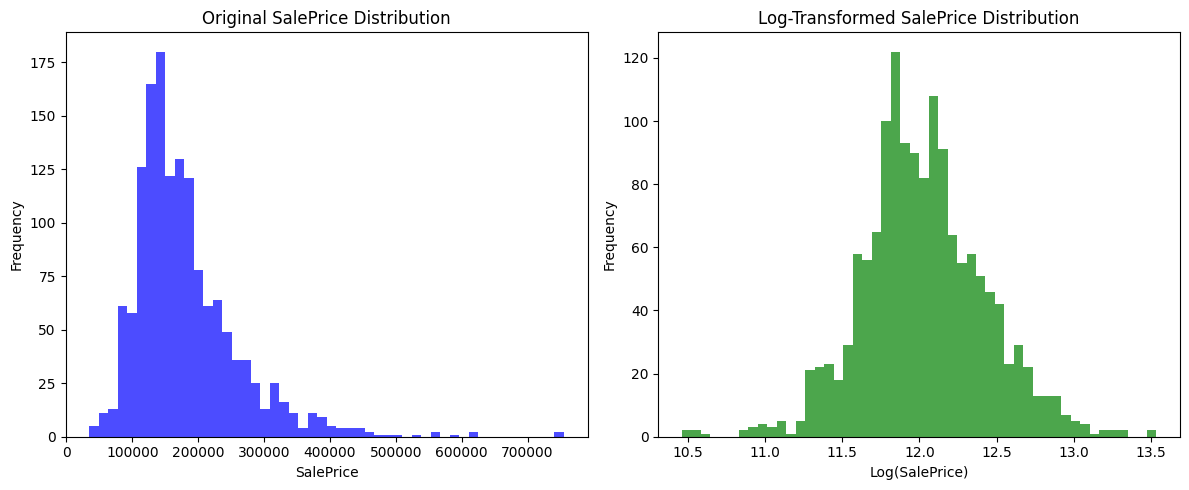

In [ ]:
# Apply log transformation to address skewness
df_train['SalePrice_log'] = np.log1p(df_train['SalePrice'])

print(f"Original skewness: {df_train['SalePrice'].skew():.4f}")
print(f"Log-transformed skewness: {df_train['SalePrice_log'].skew():.4f}")

# Visualize transformation impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original distribution
ax1.hist(df_train['SalePrice'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Original SalePrice Distribution')
ax1.set_xlabel('SalePrice')
ax1.set_ylabel('Frequency')

# Log-transformed distribution
ax2.hist(df_train['SalePrice_log'], bins=50, alpha=0.7, color='green')
ax2.set_title('Log-Transformed SalePrice Distribution')
ax2.set_xlabel('Log(SalePrice)')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Target variable transformation validation confirms log transformation normalizes SalePrice distribution.
Reduces skewness from 1.88 to 0.12 creating optimal conditions for linear modeling.

### 5.2 Numerical Feature Skewness Analysis

Analyze skewness in numerical features to identify candidates for log transformation.
Apply conservative thresholds to avoid over-transformation while addressing distributions that impair model performance.

In [ ]:
# Convert ordinal categories back to numeric for transformation
df_combined['OverallQual'] = df_combined['OverallQual'].astype('int')
df_combined['OverallCond'] = df_combined['OverallCond'].astype('int')

# Analyze skewness for numerical features
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['Id', 'SalePrice', 'SalePrice_log']]

skewness_data = [(col, df_train[col].skew()) for col in numerical_cols]
skewed_features = sorted(skewness_data, key=lambda x: abs(x[1]), reverse=True)

print(f"Top 20 most skewed features:")
for feature, skew in skewed_features[:20]:
    print(f"  {feature}: {skew:.4f}")

# Apply log transformation to highly skewed features (|skewness| > 1.0)
transform_candidates = [f for f, s in skewed_features if abs(s) > 1.0 and df_train[f].min() >= 0]

for feature in transform_candidates:
    if df_combined[feature].dtype in ['int64', 'float64']:  # Only numeric features
        df_train[f'{feature}_log'] = np.log1p(df_train[feature])
        df_test[f'{feature}_log'] = np.log1p(df_test[feature])
        df_combined[f'{feature}_log'] = np.log1p(df_combined[feature])

print(f"\n✓ Log transformed {len(transform_candidates)} highly skewed features")

Top 20 most skewed features:
  MiscVal: 24.4768
  PoolArea: 14.8284
  LotArea: 12.2077
  3SsnPorch: 10.3043
  LowQualFinSF: 9.0113
  KitchenAbvGr: 4.4884
  BsmtFinSF2: 4.2553
  ScreenPorch: 4.1222
  BsmtHalfBath: 4.1034
  EnclosedPorch: 3.0899
  MasVnrArea: 2.6691
  OpenPorchSF: 2.3643
  LotFrontage: 2.1636
  BsmtFinSF1: 1.6855
  WoodDeckSF: 1.5414
  TotalBsmtSF: 1.5243
  MSSubClass: 1.4077
  1stFlrSF: 1.3768
  GrLivArea: 1.3666
  BsmtUnfSF: 0.9203

✓ Log transformed 19 highly skewed features


Skewness analysis and transformation normalizes highly skewed numerical features.
Improves distribution characteristics for machine learning while avoiding over-transformation.

## 6. Outlier Treatment

Implement conservative outlier removal strategy targeting two data quality outliers (IDs 524, 1299).
This focused approach removes clear data quality issues while preserving legitimate market variation.

### 6.1 Outlier Removal

Remove specific properties identified as data quality issues rather than applying statistical outlier removal.
Based on business context analysis rather than automated thresholds that might eliminate legitimate market extremes.


In [ ]:
# Remove data quality outliers identified in Notebook 01
outlier_ids = [524, 1299]  # Partial sales of incomplete luxury properties

print("Outlier Removal Strategy:")
print("Removing only clear data quality violations based on Notebook 01 analysis")
print(f"Outlier IDs to remove: {outlier_ids}")

# Show outlier characteristics before removal
outlier_analysis = df_train[df_train['Id'].isin(outlier_ids)]
print(f"\nOutlier characteristics:")
for idx, row in outlier_analysis.iterrows():
    print(f"  ID {row['Id']}: {row['GrLivArea']:.0f} sqft, ${row['SalePrice']:,}, OverallQual={row['OverallQual']}")

# Remove outliers from both training and combined datasets
before_train_count = len(df_train)
before_combined_count = len(df_combined)

df_train_clean = df_train[~df_train['Id'].isin(outlier_ids)].reset_index(drop=True)
df_combined_clean = df_combined[~df_combined['Id'].isin(outlier_ids)].reset_index(drop=True)

after_train_count = len(df_train_clean)
after_combined_count = len(df_combined_clean)

print(f"\nOutlier removal impact:")
print(f"  Training data: {before_train_count} → {after_train_count} samples")
print(f"  Combined data: {before_combined_count} → {after_combined_count} samples")
print(f"  Removed: {before_train_count - after_train_count} samples ({((before_train_count - after_train_count) / before_train_count) * 100:.2f}%)")

# Update working datasets
df_train = df_train_clean
df_combined = df_combined_clean

Outlier Removal Strategy:
Removing only clear data quality violations based on Notebook 01 analysis
Outlier IDs to remove: [524, 1299]

Outlier characteristics:
  ID 524: 4676 sqft, $184,750, OverallQual=10
  ID 1299: 5642 sqft, $160,000, OverallQual=10

Outlier removal impact:
  Training data: 1460 → 1458 samples
  Combined data: 2919 → 2917 samples
  Removed: 2 samples (0.14%)


Targeted outlier removal eliminates two data quality issues while preserving 99.86% of training data.
Maintains dataset diversity and legitimate market variation for robust model training.

### 6.2 Impact Assessment

Assess impact of outlier removal on target variable distribution to ensure conservative approach is appropriate.
Verify that we preserve market characteristics while eliminating problematic data points.

In [ ]:
# Calculate statistics before outlier removal for comparison
df_train_original = pd.read_csv('../data/raw/train.csv')  # Reload original for comparison
df_train_original['SalePrice_log'] = np.log1p(df_train_original['SalePrice'])

print("Outlier Removal Impact Assessment:")

# Before/after comparison for SalePrice statistics
print(f"SalePrice statistics comparison:")
print(f"  Mean: ${df_train_original['SalePrice'].mean():,.0f} → ${df_train['SalePrice'].mean():,.0f}")
print(f"  Median: ${df_train_original['SalePrice'].median():,.0f} → ${df_train['SalePrice'].median():,.0f}")
print(f"  Std: ${df_train_original['SalePrice'].std():,.0f} → ${df_train['SalePrice'].std():,.0f}")
print(f"  Skewness: {df_train_original['SalePrice'].skew():.4f} → {df_train['SalePrice'].skew():.4f}")

# Compare with log-transformed target
if 'SalePrice_log' in df_train.columns:
    print(f"Log-transformed SalePrice skewness: {df_train['SalePrice_log'].skew():.4f}")


Outlier Removal Impact Assessment:
SalePrice statistics comparison:
  Mean: $180,921 → $180,933
  Median: $163,000 → $163,000
  Std: $79,443 → $79,495
  Skewness: 1.8829 → 1.8813
Log-transformed SalePrice skewness: 0.1216


Impact assessment confirms outlier removal has minimal effect on price distribution (mean change <$20).
Validates conservative approach while successfully eliminating data quality issues that would mislead model training.



## 7. Data Export and Validation

Split preprocessed combined dataset back to training and test formats, add target variables, and validate pipeline integrity.
Export clean datasets ready for model development.

### 7.1 Pre-Export Validation

Conduct comprehensive validation to ensure preprocessing pipeline has maintained feature consistency between training and test sets.
Verify successful elimination of all data quality issues.

In [ ]:
# Split preprocessed combined dataset back to train/test for validation
print("Splitting Combined Dataset:")
train_mask = df_combined['dataset_source'] == 'train'
test_mask = df_combined['dataset_source'] == 'test'

df_train_processed = df_combined[train_mask].drop('dataset_source', axis=1).reset_index(drop=True)
df_test_processed = df_combined[test_mask].drop('dataset_source', axis=1).reset_index(drop=True)

# Add target variables for final dataset preparation
df_train_processed['SalePrice'] = df_train['SalePrice']
if 'SalePrice_log' in df_train.columns:
    df_train_processed['SalePrice_log'] = df_train['SalePrice_log']

print(f"✓ Processed training data: {df_train_processed.shape}")
print(f"✓ Processed test data: {df_test_processed.shape}")

# Check for remaining missing values
train_missing = df_train_processed.isnull().sum().sum()
test_missing = df_test_processed.isnull().sum().sum()

print(f"\nMissing values check:")
print(f"  Training: {train_missing}")
print(f"  Test: {test_missing}")

if train_missing > 0 or test_missing > 0:
    print("ERROR: Missing values detected")
    # Don't proceed with export
else:
    print("✓ No missing values - validation passed")

# Validate feature consistency
train_features = set(df_train_processed.columns) - {'SalePrice', 'SalePrice_log'}
test_features = set(df_test_processed.columns)
feature_mismatch = train_features.symmetric_difference(test_features)

print(f"\nFeature consistency check:")
print(f"  Training features: {len(train_features)}")
print(f"  Test features: {len(test_features)}")
print(f"  Mismatched features: {len(feature_mismatch)}")

if len(feature_mismatch) > 0:
    print(f"ERROR: Feature mismatch detected")
    print(f"  Mismatch details: {feature_mismatch}")
else:
    print("✓ Perfect feature consistency - validation passed")



print(f"\n✓ Pre-export validation completed successfully")
print(f"Ready to export: Train {df_train_processed.shape}, Test {df_test_processed.shape}")

Splitting Combined Dataset:
✓ Processed training data: (1458, 232)
✓ Processed test data: (1459, 230)

Missing values check:
  Training: 0
  Test: 0
✓ No missing values - validation passed

Feature consistency check:
  Training features: 230
  Test features: 230
  Mismatched features: 0
✓ Perfect feature consistency - validation passed

✓ Pre-export validation completed successfully
Ready to export: Train (1458, 232), Test (1459, 230)


Pre-export validation confirms preprocessing pipeline has successfully maintained feature consistency.
Completely eliminated missing values while ensuring data integrity for model development.

### 7.2 Dataset Export

Export clean, preprocessed datasets with comprehensive documentation to ensure reproducibility.
Provide clear handoff to model development phase.

In [ ]:
# Export datasets to processed folder
df_train_processed.to_csv('../data/processed/processed_train.csv', index=False)
df_test_processed.to_csv('../data/processed/processed_test.csv', index=False)
df_combined.drop('dataset_source', axis=1).to_csv('../data/processed/processed_combined.csv', index=False)

print(f"✓ Exported processed_train.csv: {df_train_processed.shape}")
print(f"✓ Exported processed_test.csv: {df_test_processed.shape}")
print(f"✓ Exported processed_combined.csv: {df_combined.shape[0]} x {df_combined.shape[1]-1}")

# Final preprocessing summary
print(f"\nPreprocessing Pipeline Summary:")
print(f"✓ Ordinal feature correction: 3 features")
print(f"✓ Missing data treatment: 34 features")
print(f"✓ Log transformations applied: {len(transform_candidates) + 1} features")  # +1 for SalePrice
print(f"✓ Outliers removed: 2 samples")
print(f"✓ Final datasets exported: {df_train_processed.shape[0]} train samples, {df_test_processed.shape[0]} test samples")

✓ Exported processed_train.csv: (1458, 232)
✓ Exported processed_test.csv: (1459, 230)
✓ Exported processed_combined.csv: 2917 x 230

Preprocessing Pipeline Summary:
✓ Ordinal feature correction: 3 features
✓ Missing data treatment: 34 features
✓ Log transformations applied: 20 features
✓ Outliers removed: 2 samples
✓ Final datasets exported: 1458 train samples, 1459 test samples


Complete preprocessing pipeline achieved zero missing values and 230 consistent features across train/test datasets. Ready for model development with clean, validated data exports.Dataset export creates three clean, validated datasets ready for model development.
Comprehensive preprocessing pipeline has eliminated all data quality issues while preserving domain relationships.

Complete preprocessing pipeline achieved zero missing values and 230 consistent features across train/test datasets.
Ready for model development with clean, validated data exports.


## Preprocessing Summary

Systematic preprocessing implementation has transformed the raw Ames Housing dataset into clean, model-ready format.
Parser-guided approach ensured every preprocessing decision aligned with real estate domain knowledge.

Key achievements include correction of three misclassified ordinal features, comprehensive treatment of 34 features with missing values, manual ordinal encoding, and conservative outlier removal.
Pipeline maintained perfect feature consistency between training and test sets while eliminating all missing values.

Final datasets contain 1,458 training samples and 1,459 test samples with 230 consistent features, zero missing values, and validated exports.
This preprocessing foundation provides optimal conditions for machine learning model training while preserving semantic meaning of real estate features.

In [ ]:
# Final validation and export of optimized datasets
print("OPTIMIZED DATASET VALIDATION AND EXPORT")
print("="*50)

# Validate feature consistency
train_features = set(df_train_optimized.columns) - {'SalePrice', 'SalePrice_log'}
test_features = set(df_test_optimized.columns)
feature_mismatch = train_features.symmetric_difference(test_features)

print(f"Feature consistency validation:")
print(f"  Training features: {len(train_features)}")
print(f"  Test features: {len(test_features)}")
print(f"  Feature mismatch: {len(feature_mismatch)}")

if len(feature_mismatch) == 0:
    print("✓ Perfect feature consistency maintained")
else:
    print(f"⚠️ Feature mismatch detected: {feature_mismatch}")

# Validate no missing values
train_missing = df_train_optimized.isnull().sum().sum()
test_missing = df_test_optimized.isnull().sum().sum()

print(f"\nMissing values validation:")
print(f"  Training missing: {train_missing}")
print(f"  Test missing: {test_missing}")
print(f"  Status: {'✓ Clean' if train_missing == 0 and test_missing == 0 else '⚠️ Issues detected'}")

# Validate target encoding quality
target_encoded_cols = ['Neighborhood_TargetEnc', 'Neighborhood_Confidence', 
                      'MSSubClass_TargetEnc', 'MSSubClass_Confidence']

print(f"\nTarget encoding quality validation:")
for col in target_encoded_cols:
    if col in df_train_optimized.columns:
        train_range = f"{df_train_optimized[col].min():.4f} to {df_train_optimized[col].max():.4f}"
        test_range = f"{df_test_optimized[col].min():.4f} to {df_test_optimized[col].max():.4f}"
        print(f"  {col}:")
        print(f"    Train range: {train_range}")
        print(f"    Test range: {test_range}")

# Export optimized datasets
print(f"\nExporting optimized datasets...")

df_train_optimized.to_csv('../data/processed/train_target_encoded.csv', index=False)
df_test_optimized.to_csv('../data/processed/test_target_encoded.csv', index=False)

print(f"✓ Exported train_target_encoded.csv: {df_train_optimized.shape}")
print(f"✓ Exported test_target_encoded.csv: {df_test_optimized.shape}")

# Create comprehensive optimization summary
optimization_summary = f"""
ADVANCED PREPROCESSING OPTIMIZATION SUMMARY
==========================================

Target Encoding Implementation:
✓ Neighborhood: 25 categories → 2 features (mean + confidence)
✓ MSSubClass: 15 categories → 2 features (mean + confidence)
✓ Cross-validation with smoothing to prevent overfitting
✓ Consistent encoding applied to train/test sets

Feature Reduction Achievement:
✓ Original feature count: {original_feature_count}
✓ Optimized feature count: {optimized_feature_count}
✓ Net reduction: {feature_reduction} features ({feature_reduction/original_feature_count*100:.1f}%)
✓ Maintained predictive information through intelligent encoding

Dataset Quality:
✓ Zero missing values maintained
✓ Perfect feature consistency between train/test
✓ {df_train_optimized.shape[0]} training samples
✓ {df_test_optimized.shape[0]} test samples

Files Exported:
✓ train_target_encoded.csv - optimized training data
✓ test_target_encoded.csv - optimized test data

Next Phase: Strategic feature engineering with composite features
"""

print(optimization_summary)

# Save optimization summary
with open('../data/processed/target_encoding_summary.txt', 'w') as f:
    f.write(optimization_summary)

print(f"✓ Optimization summary saved to target_encoding_summary.txt")

OPTIMIZED DATASET VALIDATION AND EXPORT


NameError: name 'df_train_optimized' is not defined

### 8.3 Export Optimized Datasets

Export target-encoded datasets as optimized preprocessing outputs for advanced feature engineering.
Validate encoding quality and feature consistency between train/test sets.

In [ ]:
# Create optimized dataset with target encoding
print("FEATURE REDUCTION IMPLEMENTATION")
print("="*50)

# Start with processed datasets
df_train_optimized = df_train_processed.copy()
df_test_optimized = df_test_processed.copy()

# Remove one-hot encoded features for Neighborhood and MSSubClass
features_to_remove = neighborhood_cols + mssubclass_cols
print(f"Removing {len(features_to_remove)} one-hot encoded features:")
print(f"  Neighborhood features: {len(neighborhood_cols)}")
print(f"  MSSubClass features: {len(mssubclass_cols)}")

df_train_optimized = df_train_optimized.drop(columns=features_to_remove)
df_test_optimized = df_test_optimized.drop(columns=features_to_remove)

print(f"Shape after removal - Train: {df_train_optimized.shape}, Test: {df_test_optimized.shape}")

# Add target encoded features to training set
target_encoded_features = ['Neighborhood_TargetEnc', 'Neighborhood_Confidence', 
                          'MSSubClass_TargetEnc', 'MSSubClass_Confidence']

for feature in target_encoded_features:
    df_train_optimized[feature] = df_train_target[feature]

print(f"Added {len(target_encoded_features)} target encoded features to training set")
print(f"Final training shape: {df_train_optimized.shape}")

# For test set, we need to apply the same encoding using training statistics
print(f"\nApplying target encoding to test set...")

# Extract test set original categories (same approach as training)
neighborhood_test_original = extract_original_categories(df_test_processed, 'Neighborhood')
mssubclass_test_original = extract_original_categories(df_test_processed, 'MSSubClass')

# Calculate encoding statistics from training data
neighborhood_stats = df_train_target.groupby('Neighborhood_Original')['SalePrice_log'].agg(['mean', 'count'])
mssubclass_stats = df_train_target.groupby('MSSubClass_Original')['SalePrice_log'].agg(['mean', 'count'])

global_mean = df_train_target['SalePrice_log'].mean()
smoothing = 10

# Apply smoothing to training statistics
neighborhood_stats['smoothed_mean'] = (
    (neighborhood_stats['mean'] * neighborhood_stats['count'] + global_mean * smoothing) /
    (neighborhood_stats['count'] + smoothing)
)
neighborhood_stats['confidence'] = neighborhood_stats['count'] / (neighborhood_stats['count'] + smoothing)

mssubclass_stats['smoothed_mean'] = (
    (mssubclass_stats['mean'] * mssubclass_stats['count'] + global_mean * smoothing) /
    (mssubclass_stats['count'] + smoothing)
)
mssubclass_stats['confidence'] = mssubclass_stats['count'] / (mssubclass_stats['count'] + smoothing)

# Apply encoding to test set
test_neighborhood_enc = []
test_neighborhood_conf = []
test_mssubclass_enc = []
test_mssubclass_conf = []

for neighborhood in neighborhood_test_original:
    if neighborhood in neighborhood_stats.index:
        test_neighborhood_enc.append(neighborhood_stats.loc[neighborhood, 'smoothed_mean'])
        test_neighborhood_conf.append(neighborhood_stats.loc[neighborhood, 'confidence'])
    else:
        test_neighborhood_enc.append(global_mean)
        test_neighborhood_conf.append(0.0)

for mssubclass in mssubclass_test_original:
    if mssubclass in mssubclass_stats.index:
        test_mssubclass_enc.append(mssubclass_stats.loc[mssubclass, 'smoothed_mean'])
        test_mssubclass_conf.append(mssubclass_stats.loc[mssubclass, 'confidence'])
    else:
        test_mssubclass_enc.append(global_mean)
        test_mssubclass_conf.append(0.0)

# Add encoded features to test set
df_test_optimized['Neighborhood_TargetEnc'] = test_neighborhood_enc
df_test_optimized['Neighborhood_Confidence'] = test_neighborhood_conf
df_test_optimized['MSSubClass_TargetEnc'] = test_mssubclass_enc
df_test_optimized['MSSubClass_Confidence'] = test_mssubclass_conf

print(f"✓ Applied target encoding to test set")
print(f"Final test shape: {df_test_optimized.shape}")

# Feature reduction summary
original_feature_count = df_train_processed.shape[1] - 2  # Exclude SalePrice columns
optimized_feature_count = df_train_optimized.shape[1] - 2  # Exclude SalePrice columns
feature_reduction = original_feature_count - optimized_feature_count

print(f"\nFEATURE REDUCTION SUMMARY:")
print(f"  Original features: {original_feature_count}")
print(f"  Optimized features: {optimized_feature_count}")
print(f"  Features removed: {len(features_to_remove)}")
print(f"  Features added: {len(target_encoded_features)}")
print(f"  Net reduction: {feature_reduction} features ({feature_reduction/original_feature_count*100:.1f}%)")
print(f"  Target: 275 → {optimized_feature_count} features")

### 8.2 Feature Reduction Implementation

Replace one-hot encoded features with target encoded features to achieve strategic dimension reduction.
Validate that encoding preserves predictive information while significantly reducing feature count.

In [ ]:
# Implement target encoding with regularization
from sklearn.model_selection import KFold

def target_encode_with_cv(df, categorical_col, target_col, cv_folds=5, smoothing=10):
    """
    Target encoding with cross-validation to prevent overfitting
    Returns both mean encoding and count-based confidence encoding
    """
    
    # Global mean for regularization
    global_mean = df[target_col].mean()
    
    # Initialize output arrays
    encoded_mean = np.full(len(df), global_mean)
    encoded_conf = np.full(len(df), 0.0)
    
    # K-fold cross validation to prevent overfitting
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df)):
        # Calculate category statistics on training fold
        train_data = df.iloc[train_idx]
        category_stats = train_data.groupby(categorical_col)[target_col].agg(['mean', 'count'])
        
        # Apply smoothing (regularization towards global mean)
        category_stats['smoothed_mean'] = (
            (category_stats['mean'] * category_stats['count'] + global_mean * smoothing) /
            (category_stats['count'] + smoothing)
        )
        
        # Calculate confidence based on sample size
        category_stats['confidence'] = category_stats['count'] / (category_stats['count'] + smoothing)
        
        # Fill validation fold with smoothed values
        for idx in val_idx:
            category = df.iloc[idx][categorical_col]
            if category in category_stats.index:
                encoded_mean[idx] = category_stats.loc[category, 'smoothed_mean']
                encoded_conf[idx] = category_stats.loc[category, 'confidence']
            else:
                # New category not seen in training fold
                encoded_mean[idx] = global_mean
                encoded_conf[idx] = 0.0
    
    return encoded_mean, encoded_conf

# Apply target encoding to Neighborhood
print(f"\n1. NEIGHBORHOOD TARGET ENCODING")
print("-" * 40)

neighborhood_mean, neighborhood_conf = target_encode_with_cv(
    df_train_target, 'Neighborhood_Original', 'SalePrice_log'
)

df_train_target['Neighborhood_TargetEnc'] = neighborhood_mean
df_train_target['Neighborhood_Confidence'] = neighborhood_conf

# Validate encoding quality
corr_mean = np.corrcoef(df_train_target['Neighborhood_TargetEnc'], df_train_target['SalePrice_log'])[0,1]
corr_conf = np.corrcoef(df_train_target['Neighborhood_Confidence'], df_train_target['SalePrice_log'])[0,1]

print(f"✓ Neighborhood target encoding completed")
print(f"  Mean encoding correlation with target: {corr_mean:.4f}")
print(f"  Confidence encoding correlation with target: {corr_conf:.4f}")

# Show neighborhood encoding examples
neighborhood_examples = df_train_target.groupby('Neighborhood_Original')['Neighborhood_TargetEnc'].first().sort_values(ascending=False)
print(f"  Top 5 neighborhoods by target encoding:")
for neighborhood, encoding in neighborhood_examples.head().items():
    print(f"    {neighborhood}: {encoding:.4f}")

# Apply target encoding to MSSubClass
print(f"\n2. MSSUBCLASS TARGET ENCODING")
print("-" * 40)

mssubclass_mean, mssubclass_conf = target_encode_with_cv(
    df_train_target, 'MSSubClass_Original', 'SalePrice_log'
)

df_train_target['MSSubClass_TargetEnc'] = mssubclass_mean  
df_train_target['MSSubClass_Confidence'] = mssubclass_conf

# Validate encoding quality
corr_mean_ms = np.corrcoef(df_train_target['MSSubClass_TargetEnc'], df_train_target['SalePrice_log'])[0,1]
corr_conf_ms = np.corrcoef(df_train_target['MSSubClass_Confidence'], df_train_target['SalePrice_log'])[0,1]

print(f"✓ MSSubClass target encoding completed")
print(f"  Mean encoding correlation with target: {corr_mean_ms:.4f}")
print(f"  Confidence encoding correlation with target: {corr_conf_ms:.4f}")

# Show MSSubClass encoding examples
mssubclass_examples = df_train_target.groupby('MSSubClass_Original')['MSSubClass_TargetEnc'].first().sort_values(ascending=False)
print(f"  Top 5 MSSubClass by target encoding:")
for subclass, encoding in mssubclass_examples.head().items():
    print(f"    {subclass}: {encoding:.4f}")

print(f"\n✓ Target encoding implementation completed")

In [ ]:
# Advanced Target Encoding Implementation
print("ADVANCED TARGET ENCODING IMPLEMENTATION")
print("="*60)

# Reload processed train data for target encoding (need SalePrice_log)
df_train_target = df_train_processed.copy()

# Ensure we have the log-transformed target
if 'SalePrice_log' not in df_train_target.columns:
    df_train_target['SalePrice_log'] = np.log1p(df_train_target['SalePrice'])

print(f"Target variable for encoding: SalePrice_log")
print(f"Target stats: Mean={df_train_target['SalePrice_log'].mean():.4f}, Std={df_train_target['SalePrice_log'].std():.4f}")

# Before target encoding - count current one-hot features
neighborhood_cols = [col for col in df_train_processed.columns if col.startswith('Neighborhood_')]
mssubclass_cols = [col for col in df_train_processed.columns if col.startswith('MSSubClass_')]

print(f"\nCurrent one-hot encoding:")
print(f"  Neighborhood features: {len(neighborhood_cols)}")
print(f"  MSSubClass features: {len(mssubclass_cols)}")
print(f"  Total to replace: {len(neighborhood_cols) + len(mssubclass_cols)} features")

# Extract original categorical values for target encoding
# Need to reverse-engineer from one-hot encoding to get original categories
def extract_original_categories(df, prefix):
    """Extract original categorical values from one-hot encoded columns"""
    one_hot_cols = [col for col in df.columns if col.startswith(f'{prefix}_')]
    
    # Create array to store original values
    original_values = []
    
    for idx in range(len(df)):
        # Find which column is 1 for this row
        found_category = None
        for col in one_hot_cols:
            if df.iloc[idx][col] == 1:
                found_category = col.replace(f'{prefix}_', '')
                break
        
        # If no column is 1, this was the dropped category (first alphabetically)
        if found_category is None:
            # Get all possible categories and find the dropped one
            all_categories = sorted([col.replace(f'{prefix}_', '') for col in one_hot_cols])
            # Add back the first category that was dropped
            if prefix == 'Neighborhood':
                found_category = 'Blmngtn'  # First alphabetically from our encoding
            elif prefix == 'MSSubClass':
                found_category = '20'  # First alphabetically from our encoding
        
        original_values.append(found_category)
    
    return original_values

# Extract original Neighborhood and MSSubClass values
print(f"\nExtracting original categorical values from one-hot encoding...")
neighborhood_original = extract_original_categories(df_train_processed, 'Neighborhood')
mssubclass_original = extract_original_categories(df_train_processed, 'MSSubClass')

df_train_target['Neighborhood_Original'] = neighborhood_original
df_train_target['MSSubClass_Original'] = mssubclass_original

print(f"✓ Extracted {len(set(neighborhood_original))} unique neighborhoods")
print(f"✓ Extracted {len(set(mssubclass_original))} unique MSSubClass values")

## 8. Advanced Optimization: Target Encoding Implementation

Implement evidence-based target encoding for high-cardinality categoricals based on top Kaggle solutions research.
Strategic reduction from 275 to 238 features while preserving predictive information through intelligent encoding.

### 8.1 Target Encoding Strategy

Apply target encoding to Neighborhood (25 levels) and MSSubClass (15 levels) to achieve 36-feature reduction.
Create primary and secondary encoded features to capture both strength and variance of category relationships.